In [1]:
import jax.numpy as jnp
from static_potential import StaticPotential
import matplotlib.pyplot as plt
from utils import adaptive_grid

from moving_potential import MovingPotentials
from solver import Solver

In [2]:
T_max = 10

eta = 2/5

total_time = 15
total_times = jnp.linspace(total_time, total_time, 1)

amp = 10
amplitudes = jnp.linspace(amp, amp, 1)

In [3]:
sp = StaticPotential.from_json('params.json')
mps = MovingPotentials(eta, 1, amplitudes, total_times, sp.x_left, sp.x_right)
sp, mps

(StaticPotential(
     x_left=0.000,
     x_right=20.000,
     borne_parameter=5.006e+02,
     c_prefactor=1.006e-02
 ),
 MovingPotentials(
     eta=4.000e-01,
     width=1.000e+00,
     src=0.000,
     dest=20.000,
     n_amps=1,
     n_total_times=1,
     n_profiles=2,
     profile_kinds=['Linear', 'Minjerk']
 ))

In [4]:
N_x, coord_grid, coord_step, momentum_grid, momentum_step = adaptive_grid(
    sp.x_left - 5, sp.x_right + 5, required_energy = 2 * (1 + amp), B=sp.borne_parameter)

N_x, coord_step, momentum_step

(10021,
 Array(0.00299374, dtype=float32, weak_type=True),
 Array(0.20947266, dtype=float32))

In [5]:
lin = []
minj = []

start, stop = 11, 23

nts = 2 ** jnp.arange(start, stop+1)

prev_solution = jnp.zeros((mps.n_profiles, N_x), dtype=jnp.complex64)

for N_t in nts:

    print(f"Solving for N_t = {N_t}")

    solution, _ = Solver(sp, mps).solve(coord_grid, jnp.linspace(0, T_max, N_t, dtype=jnp.complex64), momentum_grid)
    solution = solution[:,0,0,:]

    # error = (solution - prev_solution)[:, N_x // 2]
    # prev_solution = solution

    minj.append(solution[1])

Solving for N_t = 2048
Solving for N_t = 4096
Solving for N_t = 8192
Solving for N_t = 16384
Solving for N_t = 32768
Solving for N_t = 65536
Solving for N_t = 131072
Solving for N_t = 262144
Solving for N_t = 524288
Solving for N_t = 1048576
Solving for N_t = 2097152
Solving for N_t = 4194304


KeyboardInterrupt: 

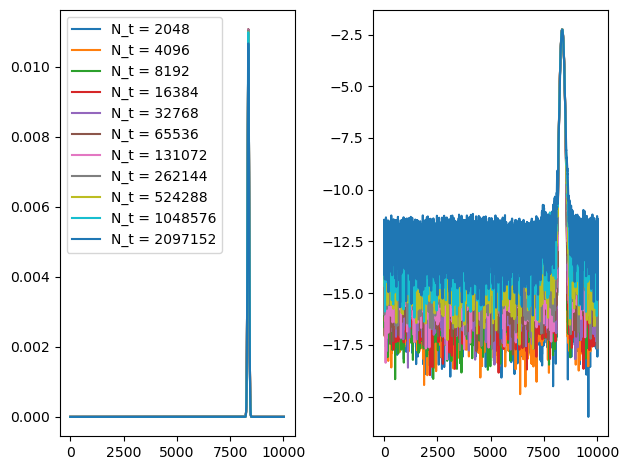

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)

for N_t, sol in zip(nts, minj):

    ax[1].plot(jnp.log(jnp.abs(sol)), label = f"N_t = {N_t}")
    ax[0].plot(jnp.abs(sol)**2, label = f"N_t = {N_t}")

plt.tight_layout()
ax[0].legend()

In [ ]:
def __dot(x, y):
    return jnp.vecdot(x, y, axis=-1)

def __dot2(x, y):
    return jnp.abs(__dot(x, y))**2

def __norm(x):
    return __dot2(x, x)

def __fid(x, y):
    return __dot2(x, y) / (__norm(x) * __norm(y))

sv = Solver(sp, mps)
f = [__norm(a) for a in minj]
f 

In [ ]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

xax = jnp.arange(start, stop+1)
ylin = jnp.log2(jnp.abs(lin))
ymin = jnp.log2(jnp.abs(minj))

linp, _ = curve_fit(linear, xax, ylin)
linfit = linear(xax, *linp)

minp, _ = curve_fit(linear, xax, ymin)
minfit = linear(xax, *minp)


plt.plot(xax,ylin)
plt.plot(xax, linfit, label = f"linear  b = {linp[0]}")

plt.plot(xax,ymin)
plt.plot(xax, minfit, label = f"minjerk b = {minp[0]}")
plt.legend()
plt.grid(ls=':')


In [9]:
minj = jnp.array(minj)
minj.shape

(11, 10021)

In [10]:
diff = jnp.diff(minj, axis=0)
diff.shape

(10, 10021)

In [11]:
mn = diff.max(axis=-1)
mn

Array([8.6447699e-07-1.9210867e-07j, 6.7870617e-03+4.7465056e-02j,
       1.2218885e-02+2.2556219e-02j, 8.3302408e-03+1.0255255e-02j,
       4.6840534e-03+4.7402903e-03j, 2.4283007e-03+2.1919161e-03j,
       1.1552200e-03+9.1679394e-04j, 4.4375658e-04+8.4422529e-05j,
       1.7770566e-04-1.9565783e-04j, 4.1164458e-04-8.4968470e-04j],      dtype=complex64)

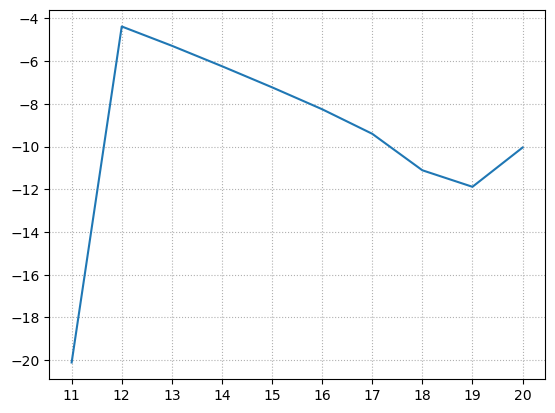

In [16]:
plt.plot(jnp.arange(start, stop)[:-2], jnp.log2(jnp.abs(mn)))
plt.xticks(jnp.arange(start, stop)[:-2])
plt.grid(ls=':')